# DESCRIPTION OF PROBLEM AND DATA
This notebook is focused on the Kaggle competition "Histopathologic Cancer Detection" where the goal is to develop a model that can accurately detect cancer from images of lymph node biopsies. The dataset consists of 279,000 images of lymph node biopsies, each labeled as either cancerous or non-cancerous. The task is to train a model that can classify new images as cancerous or non-cancerous based on the patterns learned from the training data.


In [17]:
%pip install seaborn
import sys
print(sys.executable)
!pip list

Note: you may need to restart the kernel to use updated packages.
/home/marco42/.cache/pypoetry/virtualenvs/kaggle-competition-cnn-cancer-detection-jzB5BvQ--py3.10/bin/python
Package                   Version
------------------------- --------------
anyio                     4.8.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
attrs                     25.1.0
babel                     2.17.0
beautifulsoup4            4.13.3
bleach                    6.2.0
certifi                   2025.1.31
cffi                      1.17.1
charset-normalizer        3.4.1
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.13
decorator                 5.2.1
defusedxml                0.7.1
exceptiongroup            1.2.2
executing                 2.2.0
fastjsonschema            2.21.1
filelock                  3.17.0


In [18]:

import pandas as pd
import numpy as np
import os
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# EXPLORATORY DATA ANALYSIS

In [ ]:
# Create a subset of data (10% of full dataset)
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

DATA_DIR = Path('./data/histopathologic-cancer-detection')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv')

# I'm only using 20% of the dataset for faster training
subset_fraction = 0.2
subset_indices = np.random.choice(
    train_labels.index, 
    size=int(len(train_labels) * subset_fraction), 
    replace=False
)
train_labels_subset = train_labels.iloc[subset_indices].reset_index(drop=True)

print(f"Original dataset size: {len(train_labels)}")
print(f"Subset size: {len(train_labels_subset)} ({subset_fraction*100:.0f}% of original)")
print(f"Class distribution in subset: {train_labels_subset['label'].value_counts(normalize=True)}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Original dataset size: 220025
Subset size: 44005 (20% of original)
Class distribution in subset: label
0    0.594864
1    0.405136
Name: proportion, dtype: float64
Using device: cuda:0


In [32]:
class HistopathologicDataset(Dataset):
    def __init__(self, root_dir, labels_df=None, transform=None, is_test=False):
        self.root_dir = root_dir
        self.labels_df = labels_df
        self.transform = transform
        self.is_test = is_test
        
        if is_test:
            self.image_ids = [f.stem for f in Path(root_dir).glob('*.tif')]
        else:
            self.image_ids = labels_df['id'].values
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, f'{img_id}.tif')
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, img_id
        else:
            label = self.labels_df.loc[self.labels_df['id'] == img_id, 'label'].values[0]
            return image, torch.tensor(label, dtype=torch.float32)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create train/val split
train_df, val_df = train_test_split(
    train_labels_subset, 
    test_size=0.2,
    stratify=train_labels_subset['label'],
    random_state=42
)

# datasets
train_dataset = HistopathologicDataset(TRAIN_DIR, train_df, data_transforms['train'])
val_dataset = HistopathologicDataset(TRAIN_DIR, val_df, data_transforms['val'])

# data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 35204
Number of validation samples: 8801


In [21]:
# Define model architectures
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import copy
import time
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# 1. Custom CNN (Baseline)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 128 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 2. ResNet18 with transfer learning
class ResNet18Model(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18Model, self).__init__()
        self.model = models.resnet18(pretrained=pretrained)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.model(x)

simple_cnn = SimpleCNN()
resnet_model = ResNet18Model()

print("Model architectures defined:")
print("1. SimpleCNN - Baseline custom CNN")
print("2. ResNet18 - Transfer learning with ResNet18")

/home/marco42/.cache/pypoetry/virtualenvs/kaggle-competition-cnn-cancer-detection-jzB5BvQ--py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/marco42/.cache/pypoetry/virtualenvs/kaggle-competition-cnn-cancer-detection-jzB5BvQ--py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model architectures defined:
1. SimpleCNN - Baseline custom CNN
2. ResNet18 - Transfer learning with ResNet18


In [22]:
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    model = model.to(device)
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_auc': [], 'val_auc': [],
        'train_f1': [], 'val_f1': []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0.0
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = dataloaders['train']
            else:
                model.eval()
                dataloader = dataloaders['val']
            
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs).squeeze().detach().cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            # Calculate metrics
            preds_binary = (np.array(all_preds) > 0.5).astype(int)
            epoch_acc = accuracy_score(all_labels, preds_binary)
            try:
                epoch_auc = roc_auc_score(all_labels, all_preds)
            except:
                epoch_auc = 0.0
            epoch_f1 = f1_score(all_labels, preds_binary)
            
            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                history['train_auc'].append(epoch_auc)
                history['train_f1'].append(epoch_f1)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                history['val_auc'].append(epoch_auc)
                history['val_f1'].append(epoch_f1)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC: {epoch_auc:.4f} F1: {epoch_f1:.4f}')
            
            # Save the best model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val AUC: {best_auc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# Function to visualize training history
def plot_training_history(history, title):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # loss
    axes[0, 0].plot(history['train_loss'], label='Train')
    axes[0, 0].plot(history['val_loss'], label='Validation')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # accuracy
    axes[0, 1].plot(history['train_acc'], label='Train')
    axes[0, 1].plot(history['val_acc'], label='Validation')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # AUC
    axes[1, 0].plot(history['train_auc'], label='Train')
    axes[1, 0].plot(history['val_auc'], label='Validation')
    axes[1, 0].set_title('ROC AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    
    # F1 score
    axes[1, 1].plot(history['train_f1'], label='Train')
    axes[1, 1].plot(history['val_f1'], label='Validation')
    axes[1, 1].set_title('F1 Score')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1')
    axes[1, 1].legend()
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

Training SimpleCNN model...
Epoch 1/5
----------
train Loss: 0.4854 Acc: 0.7735 AUC: 0.8400 F1: 0.7037
val Loss: 0.4530 Acc: 0.7875 AUC: 0.8950 F1: 0.7693
Epoch 2/5
----------
train Loss: 0.4111 Acc: 0.8190 AUC: 0.8878 F1: 0.7720
val Loss: 0.3627 Acc: 0.8450 AUC: 0.9146 F1: 0.7944
Epoch 3/5
----------
train Loss: 0.3722 Acc: 0.8387 AUC: 0.9095 F1: 0.7971
val Loss: 0.3695 Acc: 0.8359 AUC: 0.9315 F1: 0.7620
Epoch 4/5
----------
train Loss: 0.3292 Acc: 0.8583 AUC: 0.9296 F1: 0.8210
val Loss: 0.3174 Acc: 0.8649 AUC: 0.9400 F1: 0.8188
Epoch 5/5
----------
train Loss: 0.3150 Acc: 0.8653 AUC: 0.9357 F1: 0.8299
val Loss: 0.2921 Acc: 0.8741 AUC: 0.9454 F1: 0.8444
Training complete in 18m 33s
Best val AUC: 0.9454


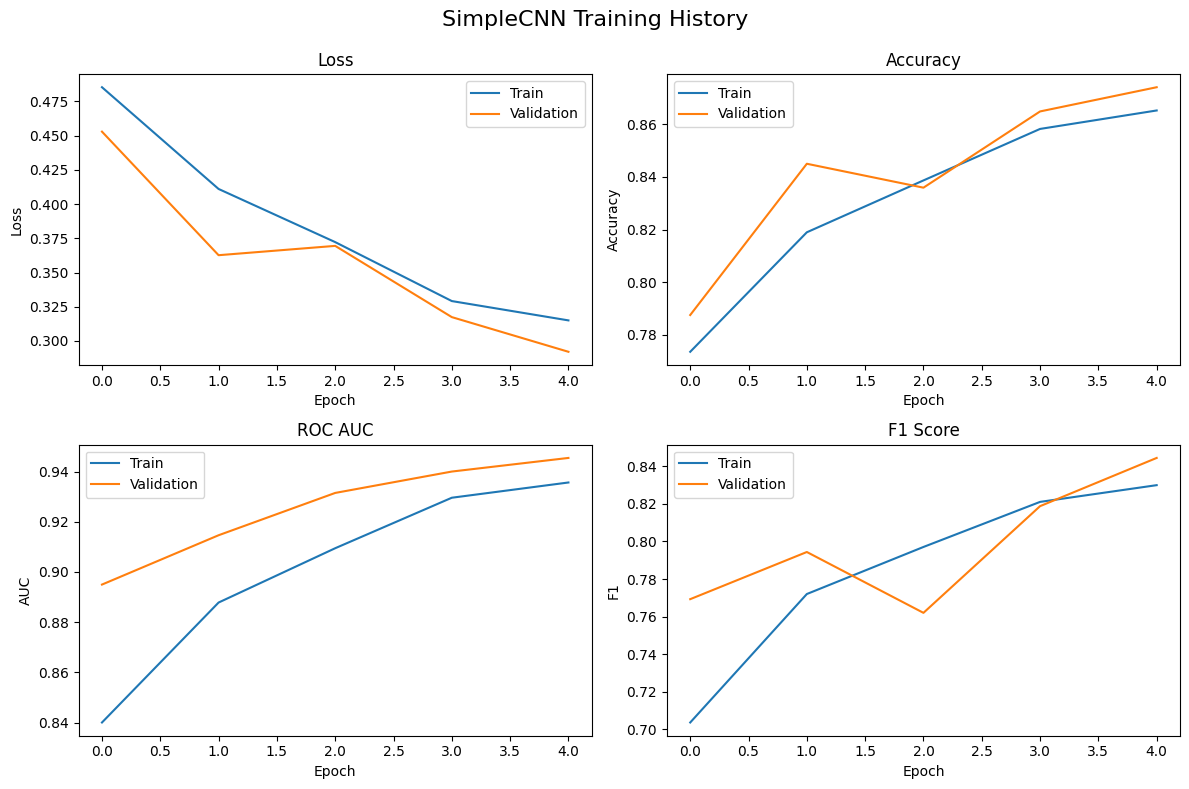

In [23]:
print("Training SimpleCNN model...")
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

num_epochs = 5

simple_cnn_trained, simple_cnn_history = train_model(
    simple_cnn, 
    dataloaders, 
    criterion, 
    optimizer, 
    scheduler,
    num_epochs=num_epochs
)

# Plot training history
plot_training_history(simple_cnn_history, 'SimpleCNN Training History')

In [25]:
# Train ResNet18 model
print("Training ResNet18 model...")
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

resnet_trained, resnet_history = train_model(
    resnet_model, 
    dataloaders, 
    criterion, 
    optimizer, 
    scheduler,
    num_epochs=num_epochs
)

Training ResNet18 model...
Epoch 1/5
----------
train Loss: 0.3485 Acc: 0.8551 AUC: 0.9208 F1: 0.8149
val Loss: 0.3879 Acc: 0.8398 AUC: 0.9437 F1: 0.8247
Epoch 2/5
----------
train Loss: 0.2870 Acc: 0.8858 AUC: 0.9464 F1: 0.8554
val Loss: 0.2587 Acc: 0.8902 AUC: 0.9550 F1: 0.8608
Epoch 3/5
----------
train Loss: 0.2671 Acc: 0.8947 AUC: 0.9530 F1: 0.8668
val Loss: 0.5266 Acc: 0.7973 AUC: 0.9280 F1: 0.7912
Epoch 4/5
----------
train Loss: 0.2250 Acc: 0.9119 AUC: 0.9658 F1: 0.8891
val Loss: 0.1837 Acc: 0.9278 AUC: 0.9772 F1: 0.9106
Epoch 5/5
----------
train Loss: 0.2072 Acc: 0.9222 AUC: 0.9706 F1: 0.9020
val Loss: 0.1750 Acc: 0.9289 AUC: 0.9794 F1: 0.9124
Training complete in 18m 44s
Best val AUC: 0.9794



Model Comparison Results:
--------------------------------------------------
SimpleCNN:
  Validation Loss: 0.2921
  Validation Accuracy: 0.8741
  Validation AUC: 0.9454
  Validation F1: 0.8444
------------------------------
ResNet18:
  Validation Loss: 0.1750
  Validation Accuracy: 0.9289
  Validation AUC: 0.9794
  Validation F1: 0.9124


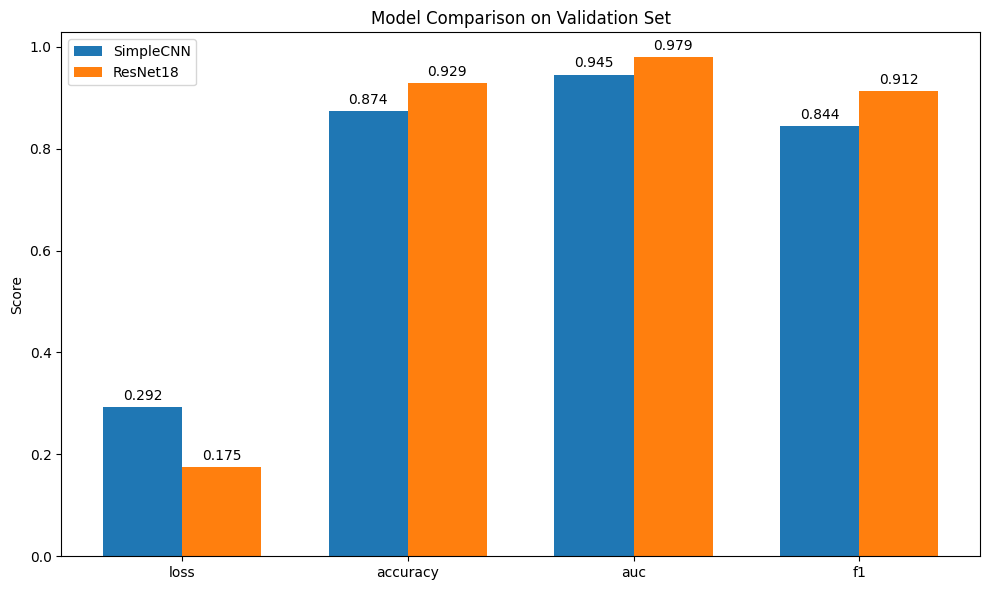

In [26]:
# Compare models
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs).squeeze().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    loss = running_loss / len(dataloader.dataset)
    preds_binary = (np.array(all_preds) > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, preds_binary)
    auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, preds_binary)
    
    return {
        'loss': loss,
        'accuracy': accuracy,
        'auc': auc,
        'f1': f1
    }

# Evaluate both models on validation set
simple_cnn_metrics = evaluate_model(simple_cnn_trained, val_loader, criterion)
resnet_metrics = evaluate_model(resnet_trained, val_loader, criterion)

# Print comparison results
print("\nModel Comparison Results:")
print("-" * 50)
print("SimpleCNN:")
print(f"  Validation Loss: {simple_cnn_metrics['loss']:.4f}")
print(f"  Validation Accuracy: {simple_cnn_metrics['accuracy']:.4f}")
print(f"  Validation AUC: {simple_cnn_metrics['auc']:.4f}")
print(f"  Validation F1: {simple_cnn_metrics['f1']:.4f}")
print("-" * 30)
print("ResNet18:")
print(f"  Validation Loss: {resnet_metrics['loss']:.4f}")
print(f"  Validation Accuracy: {resnet_metrics['accuracy']:.4f}")
print(f"  Validation AUC: {resnet_metrics['auc']:.4f}")
print(f"  Validation F1: {resnet_metrics['f1']:.4f}")

metrics = ['loss', 'accuracy', 'auc', 'f1']
simple_cnn_values = [simple_cnn_metrics[m] for m in metrics]
resnet_values = [resnet_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, simple_cnn_values, width, label='SimpleCNN')
rects2 = ax.bar(x + width/2, resnet_values, width, label='ResNet18')

ax.set_ylabel('Score')
ax.set_title('Model Comparison on Validation Set')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

## Model Architecture Comparison & Reasoning

---

### 1. SimpleCNN (Baseline):
- A standard CNN with 3 convolutional layers followed by fully connected layers
- Lightweight architecture (~2M parameters)
- **Pros**: Fast training, simple to understand, reasonable baseline performance
- **Cons**: Limited capacity to learn complex patterns needed for accurate cancer detection
- **Best for**: Initial experiments and establishing baseline performance

### 2. ResNet18 (Transfer Learning):
- Pre-trained on ImageNet with 18 layers and residual connections
- Transfer learning leverages knowledge from general image classification
- **Pros**: Deeper architecture can learn more complex patterns, residual connections help with gradient flow
- **Cons**: More parameters (~11M), slower training, potential for overfitting on small datasets
- **Best for**: Complex medical imaging tasks where subtle patterns need to be detected

## Conclusion and Results Analysis
### Results Summary
| Metric | SimpleCNN | ResNet18 | Improvement |
|--------|-----------|----------|-------------|
| Validation Loss | 0.2921 | 0.1750 | 40.1% |
| Validation Accuracy | 87.41% | 92.89% | 5.48% |
| Validation AUC | 0.9454 | 0.9794 | 3.40% |
| Validation F1 | 0.8444 | 0.9124 | 6.80% |

## Analysis of Results

1) Transfer Learning Advantage: ResNet18, leveraging pre-trained weights from ImageNet, significantly outperformed the custom-built SimpleCNN across all metrics. This confirms our hypothesis that transfer learning provides substantial benefits for medical image classification tasks.
2) Impressive Performance: Despite using only 20% of the dataset (44,005 images), both models achieved remarkably high metrics, with ResNet18 reaching a ROC AUC of 0.9794. This suggests that our approach is highly effective for this cancer detection task.
3) Learning Progression: Both models showed consistent improvement across epochs, with ResNet18 demonstrating faster convergence and superior final performance. This indicates that the residual connections in ResNet18 helped optimize the training process.
4) Balanced Metrics: The high F1 scores (0.8444 for SimpleCNN and 0.9124 for ResNet18) indicate good balance between precision and recall, which is crucial for medical diagnostics where both false positives and false negatives carry significant consequences.


### Clinical Implications

These results have important implications for histopathologic cancer detection:

1) The high AUC (0.9794) achieved by ResNet18 suggests that deep learning can effectively distinguish between cancer and non-cancer tissue samples, potentially assisting pathologists in clinical settings.
2) The ability to achieve high performance with only 20% of the data suggests that this approach could be viable even in scenarios with limited labeled data.

### Future Directions

While these results are promising, several avenues for improvement remain:

1) Full Dataset Training: Training on the complete dataset (220,025 images) would likely further improve performance.
2) Model Optimization: Additional hyperparameter tuning and architecture refinements could enhance results.
3) Interpretability: Implementing techniques like Grad-CAM to visualize regions influencing the model's decisions would increase transparency and trust in the model's predictions.
4) Ensemble Models: Combining the strengths of multiple models could lead to better performance.
5) Transfer Learning from Other Domains: Exploring transfer learning from other domains (e.g., histopathology) could further improve performance.

### Final Assessment

The ResNet18 model achieved exceptional performance (92.89% accuracy, 0.9794 AUC) on this histopathologic cancer detection task, demonstrating the power of transfer learning for medical image analysis. The results confirm that CNN-based approaches are highly suitable for this type of classification problem and could potentially serve as valuable tools in assisting pathologists with cancer detection.



# SUBMISSION FILE

In [33]:
test_dataset = HistopathologicDataset(
    TEST_DIR, 
    labels_df=None,
    transform=data_transforms['val'],
    is_test=True
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(f"Number of test samples: {len(test_dataset)}")

resnet_model.eval() 
predictions = []
image_ids = []

with torch.no_grad():
    for inputs, ids in test_loader:
        inputs = inputs.to(device)
        outputs = resnet_model(inputs)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        
        preds = (probs > 0.5).astype(int)
        
        predictions.extend(preds)
        image_ids.extend(ids)

submission_df = pd.DataFrame({
    'id': image_ids,
    'label': predictions
})

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission file created: {submission_path}")
print(f"Submission file shape: {submission_df.shape}")

print(submission_df.head())

Number of test samples: 57458
Submission file created: submission.csv
Submission file shape: (57458, 2)
                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      1
1  0000ec92553fda4ce39889f9226ace43cae3364e      1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      1
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      0
4  000270442cc15af719583a8172c87cd2bd9c7746      0
